In [ ]:
import sys
from pathlib import Path
import datetime as dt
import numpy as np 
import pandas as pd
import joblib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, cross_val_score,  train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, median_absolute_error

In [ ]:
PROJPATH = Path().resolve().parent
sys.path.append((PROJPATH / 'scripts').as_posix())
import riverice_util as ru

ML_LOC = PROJPATH / "data/ML_2024"

#### Let's start with Nenana (or another location)

In [ ]:
location = "Chena River at Fairbanks"
df = pd.read_csv(ML_LOC / f"DF/DF_{location.replace(' ', '_')}", index_col=0)
df.rename(columns={'t2m': 't2m_M', 'ssr': 'ssr_M', 'sd': 'sd_M'}, inplace=True)
Xy = df.loc[1980:2023, :].dropna()
# Xy.reset_index(inplace=True, names='year')
X = Xy.iloc[:, :-1]
y = Xy.iloc[:, -1]
X_2024 = df.iloc[-1, :-1]
# X_2024 = df.reset_index(names='year').iloc[-1, :-1]

#### Feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import f_regression
from sklearn.ensemble import ExtraTreesRegressor

In [ ]:

clf = ExtraTreesRegressor(n_estimators=200)
clf = clf.fit(X, y)
clf.feature_importances_
selector = SelectFromModel(clf, prefit=True)
X_new = X[X.columns[selector.get_support()]]
X_new

,AO_DJ,PNA_DJ,Nino4_DJ,Nino4_FM,NAO_FM,EA_FM,POL_DJ,POL_FM,NenanaIceThick,sd_M
1983,1.163,0.660,0.450,0.280,-0.225,-0.705,-1.035,0.030,39.755556,0.128
1985,-1.180,-0.230,-0.795,-0.860,-0.595,-0.350,-1.405,-0.120,39.755556,0.160
1986,-1.258,0.840,-0.245,-0.195,-0.095,-0.130,-0.020,1.535,39.755556,0.085
1988,-0.135,0.265,0.705,0.295,-0.080,-0.215,0.730,-0.090,39.755556,0.093
1989,2.393,-0.620,-1.745,-1.345,1.680,-0.200,0.165,0.790,42.000000,0.121
1990,0.178,-0.260,0.020,0.345,1.145,1.430,-0.645,0.070,36.000000,0.178
1991,1.000,-0.710,0.615,0.440,0.065,0.425,0.550,0.175,38.000000,0.270
1993,2.561,-1.505,0.145,0.075,0.210,-0.925,0.540,1.685,26.000000,0.232
1995,0.370,0.295,0.820,0.710,0.880,-0.715,0.695,-0.165,34.000000,0.167
1996,-1.663,-0.030,-0.485,-0.460,-0.590,-0.885,-0.180,1.635,45.000000,0.113


In [ ]:
X_new.corrwith(y)

AO_DJ            -0.407813
PNA_DJ            0.103629
Nino4_DJ         -0.334465
Nino4_FM         -0.382796
NAO_FM           -0.301095
EA_FM            -0.081002
POL_DJ           -0.251870
POL_FM           -0.193658
NenanaIceThick    0.424256
sd_M             -0.335160
dtype: float64

Straight CV

In [ ]:
X_new

,AO_DJ,PNA_DJ,Nino4_DJ,Nino4_FM,NAO_FM,EA_FM,POL_DJ,POL_FM,NenanaIceThick,sd_M
1983,1.163,0.660,0.450,0.280,-0.225,-0.705,-1.035,0.030,39.755556,0.128
1985,-1.180,-0.230,-0.795,-0.860,-0.595,-0.350,-1.405,-0.120,39.755556,0.160
1986,-1.258,0.840,-0.245,-0.195,-0.095,-0.130,-0.020,1.535,39.755556,0.085
1988,-0.135,0.265,0.705,0.295,-0.080,-0.215,0.730,-0.090,39.755556,0.093
1989,2.393,-0.620,-1.745,-1.345,1.680,-0.200,0.165,0.790,42.000000,0.121
1990,0.178,-0.260,0.020,0.345,1.145,1.430,-0.645,0.070,36.000000,0.178
1991,1.000,-0.710,0.615,0.440,0.065,0.425,0.550,0.175,38.000000,0.270
1993,2.561,-1.505,0.145,0.075,0.210,-0.925,0.540,1.685,26.000000,0.232
1995,0.370,0.295,0.820,0.710,0.880,-0.715,0.695,-0.165,34.000000,0.167
1996,-1.663,-0.030,-0.485,-0.460,-0.590,-0.885,-0.180,1.635,45.000000,0.113


In [ ]:
cv_inner = KFold(n_splits=10, shuffle=True, random_state=43)
model = GradientBoostingRegressor(random_state=40)
    # define search space
space = {
        'min_samples_leaf': list(range(3, 6)),
        'max_depth': [2, 3, 4],
        'n_estimators': [5000],
        'learning_rate': [0.015, 0.01, 0.005],
        'subsample': [0.5],
    }
# define search
search = GridSearchCV(model, space, cv=cv_inner, scoring='neg_root_mean_squared_error', verbose=1, 
            refit=True, n_jobs=5)
# execute search
grid_result = search.fit(X, y)
# get the best performing model fit on the whole training set
best_model = grid_result.best_estimator_
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean}, {stdev}, {param}")

Fitting 10 folds for each of 27 candidates, totalling 270 fits


KeyboardInterrupt: 

In [ ]:
grid_result.cv_results_['mean_test_score'][grid_result.best_index_]

-5.742971016630923

In [ ]:
best_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.005,
 'loss': 'squared_error',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 5000,
 'n_iter_no_change': None,
 'random_state': 40,
 'subsample': 0.5,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

The mean squared error (MSE) on train set: 3.8911
The mean squared error (MSE) on test set: 51.9823
The score for this training set is 0.9504
The validation score for this test set is -4.4599
Pearson score on training set: 0.9807
Pearson score on test set: -0.1674



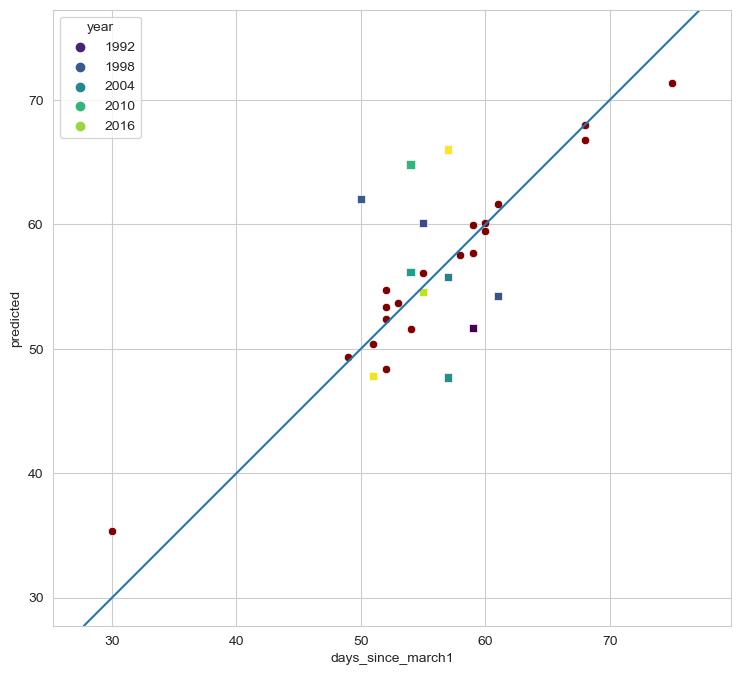

In [ ]:
random_seed = 2023
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.33, random_state=random_seed)

params_gb = {
        'min_samples_leaf': 5,
        # 'min_samples_split': 5,
        'max_depth': 2,
        # 'n_estimators': [250, 200, 150, 100],
        'n_estimators': 5000,
        'learning_rate': 0.005,
        'subsample': 0.5,
    'random_state': random_seed, 
}
model1 = GradientBoostingRegressor(**params_gb)
model2 = RandomForestRegressor(random_state=random_seed)
model2 = best_model
model3 = ExtraTreesRegressor(n_estimators=200)
# define search
model = VotingRegressor(estimators=[('gb', model1), ('rf', model2), ('lr', model3)])
model = model1
# execute search
result = model.fit(X_train, y_train)
# get the best performing model fit on the whole training set
mse = mean_squared_error(y_train, model.predict(X_train))
print("The mean squared error (MSE) on train set: {:.4f}".format(mse))
mse = mean_squared_error(y_test, model.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print(f"The score for this training set is {model.score(X_train, y_train):.4f}")
print(f"The validation score for this test set is {model.score(X_test, y_test):.4f}")
print(f"Pearson score on training set: {np.corrcoef(y_train.values, model.predict(X_train))[1, 0]:.4f}")
print(f"Pearson score on test set: {np.corrcoef(y_test.values, model.predict(X_test))[1, 0]:.4f}")
pred = best_model.predict(X_test)
print()

plot_df = pd.DataFrame(y_test)
plot_df.reset_index(inplace=True)
plot_df.columns = ['year', 'days_since_march1']
plot_df['predicted'] = model.predict(X_test)
plot_df_train = pd.DataFrame(y_train)
plot_df_train
plot_df_train.reset_index(inplace=True)
plot_df_train.columns = ['year', 'days_since_march1']
plot_df_train['predicted'] = model.predict(X_train)
plot_df_train
fig, ax = plt.subplots(1, 1, figsize=(12,8), sharex=True)
# sns.lineplot(x='year', y='days_since_march1', data=plot_df_train, ax=ax[0])
# sns.scatterplot(x='year', y='predicted', data=plot_df_train, color='red', ax=ax[0])
# sns.lineplot(x='year', y='days_since_march1', data=plot_df, ax=ax[1])
# sns.scatterplot(x='year', y='predicted', data=plot_df, color='red', ax=ax[1])
sns.scatterplot(x='days_since_march1', y='predicted', data=plot_df_train, color='maroon', ax=ax)
sns.scatterplot(x='days_since_march1', y='predicted', data=plot_df, hue='year', marker='s', palette='viridis', ax=ax)
lims = ax.get_xlim()
ax.set_ylim(lims)
ax.axline([ax.get_xlim()[0], ax.get_ylim()[0]], [ax.get_xlim()[1], ax.get_ylim()[1]])
ax.set_aspect('equal')
plt.show(fig)

In [ ]:
model.score(X_new, y)

0.6132871163370486

In [ ]:
model.score(X_train, y_train)

0.9503938289234855

In [ ]:
model.score(X_test, y_test)

-4.459949161680145

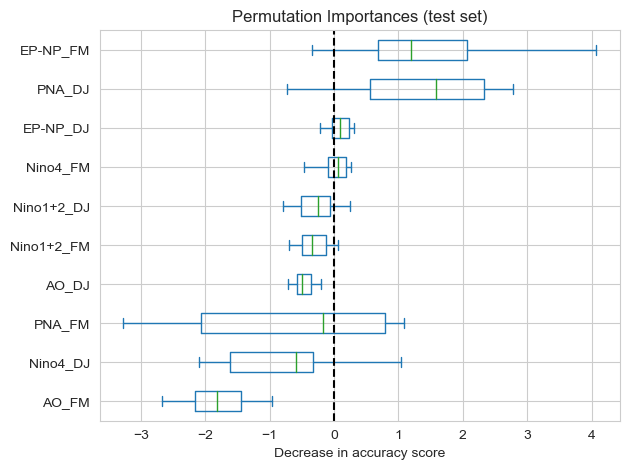

In [ ]:
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.show()

In [ ]:
sns.set_style('whitegrid')

The mean squared error (MSE) on train set: 63.6583
The mean squared error (MSE) on test set: 28.4824
The score for this training set is -0.0005
The validation score for this test set is -0.1515
Pearson score on training set: 0.0000
Pearson score on test set: nan



/Users/christine/miniconda3/envs/fiweps/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/christine/miniconda3/envs/fiweps/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


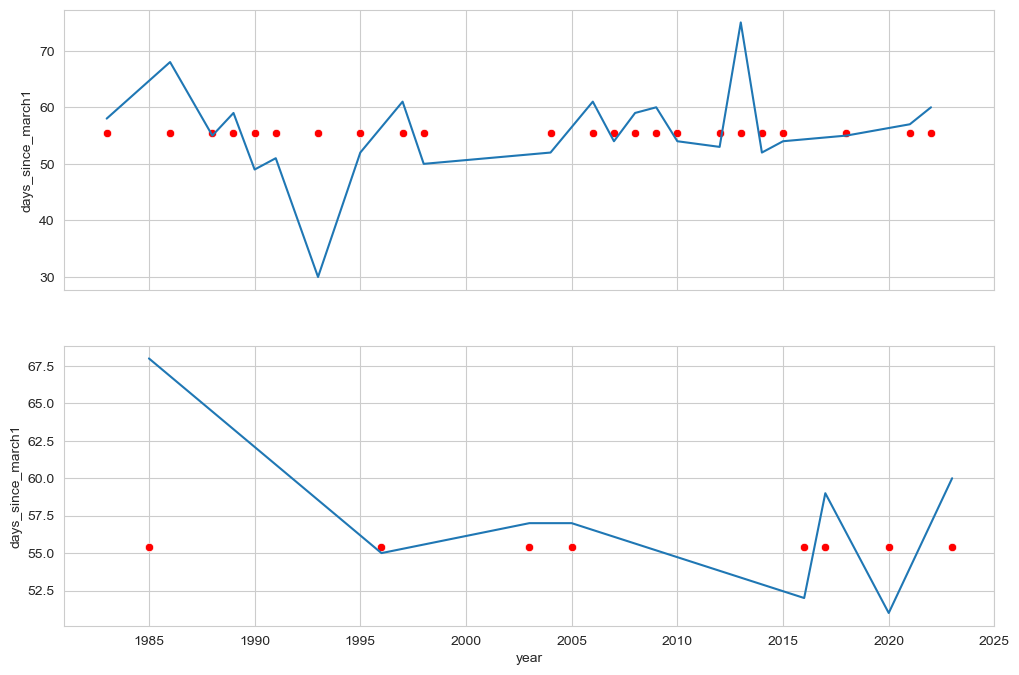

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
model = best_model

model.fit(X_train, y_train)
mse = mean_squared_error(y_train, model.predict(X_train))
print("The mean squared error (MSE) on train set: {:.4f}".format(mse))
mse = mean_squared_error(y_test, model.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print(f"The score for this training set is {model.score(X_train, y_train):.4f}")
print(f"The validation score for this test set is {model.score(X_test, y_test):.4f}")
print(f"Pearson score on training set: {np.corrcoef(y_train.values, model.predict(X_train))[1, 0]:.4f}")
print(f"Pearson score on test set: {np.corrcoef(y_test.values, model.predict(X_test))[1, 0]:.4f}")
pred = best_model.predict(X_test)
print()

plot_df = pd.DataFrame(y_test)
plot_df.reset_index(inplace=True)
plot_df.columns = ['year', 'days_since_march1']
plot_df['predicted'] = model.predict(X_test)
plot_df_train = pd.DataFrame(y_train)
plot_df_train
plot_df_train.reset_index(inplace=True)
plot_df_train.columns = ['year', 'days_since_march1']
plot_df_train['predicted'] = model.predict(X_train)
plot_df_train
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)
sns.lineplot(x='year', y='days_since_march1', data=plot_df_train, ax=ax[0])
sns.scatterplot(x='year', y='predicted', data=plot_df_train, color='red', ax=ax[0])
sns.lineplot(x='year', y='days_since_march1', data=plot_df, ax=ax[1])
sns.scatterplot(x='year', y='predicted', data=plot_df, color='red', ax=ax[1])
# sns.scatterplot(x='days_since_march1', y='predicted', data=plot_df_train, color='blue', ax=ax)
# sns.scatterplot(x='days_since_march1', y='predicted', data=plot_df, color='red', ax=ax)
# ax.set_box_aspect(1)
plt.show(fig)

In [ ]:
best_model.fit(X_new, y)
prediction = best_model.predict(pd.DataFrame(X_2024[X.columns[selector.get_support()]]).T)
since_date = dt.datetime.strptime('200003011200', "%Y%m%d%H%M")
(since_date + dt.timedelta(days=prediction.item())).date()
# ru.dayssince2date(prediction.item())

datetime.date(2000, 4, 29)

In [ ]:
pd.DataFrame(X_2024[X.columns[selector.get_support()]]).T

,AO_DJ,AO_FM,Nino1+2_DJ,Nino4_DJ,Nino4_FM,NAO_FM,EA_FM,EA-WR_DJ,POL_DJ,seaice_ber_anom_FM,NenanaIceThick,t2m
2024,-0.216,0.013,1.45,1.52,1.125,0.79,1.7,0.55,-0.91,-33419.859,49.0,12.802


### Shaply analysis

In [ ]:
import shap

In [ ]:
X_sample = shap.utils.sample(X_new, 50)

In [ ]:
explainer = shap.Explainer(best_model.predict, X_new)
shap_values = explainer(pd.DataFrame(X_2024[X.columns[selector.get_support()]]).T)
shap_values_all = explainer(X_new)
sample_ind = 20

PermutationExplainer explainer: 45it [00:25,  1.08it/s]                        


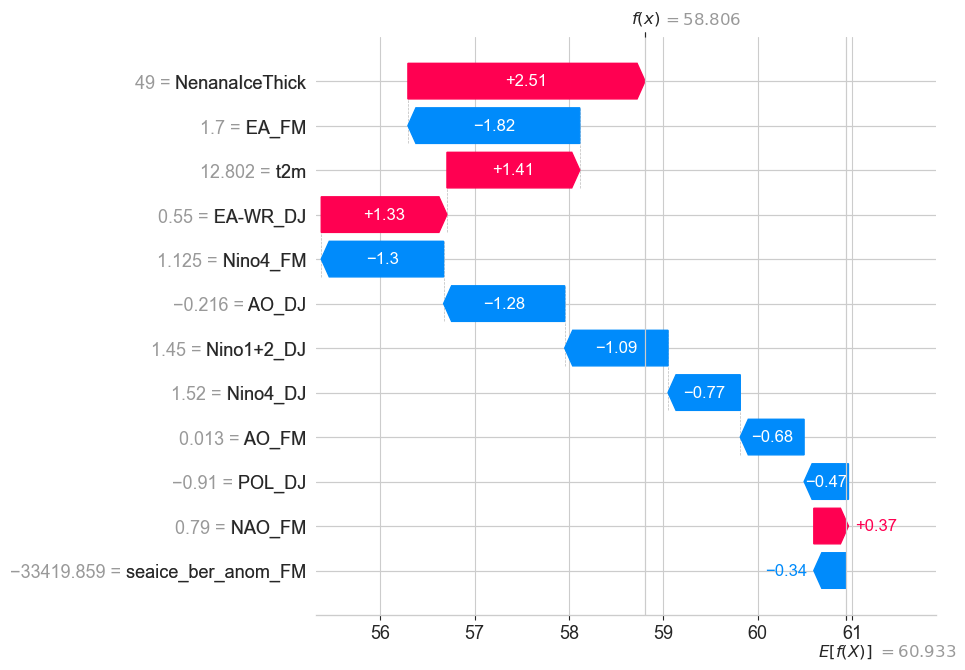

In [ ]:
ax = shap.plots.waterfall(shap_values[0], max_display=20, show=False)
# ax.set_title(f"2024, {location}")
plt.savefig("test.png",  bbox_inches='tight')
plt.show()

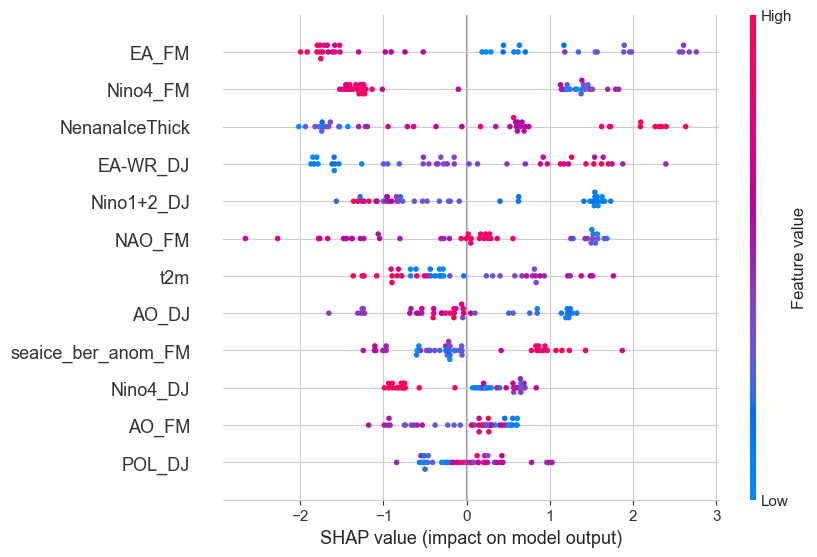

In [ ]:
shap.plots.beeswarm(shap_values_all, max_display=25)
